In [1]:
# ─────────────────────────────────────────────
# 1 : Librairies
# ─────────────────────────────────────────────

# Classic
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import polars as pl

# Probabilities
from scipy.optimize import curve_fit
from tls.probabilities import proba_gamma

popt [mu, theta, A]: [37.89810256 17.99604862  0.92443102]


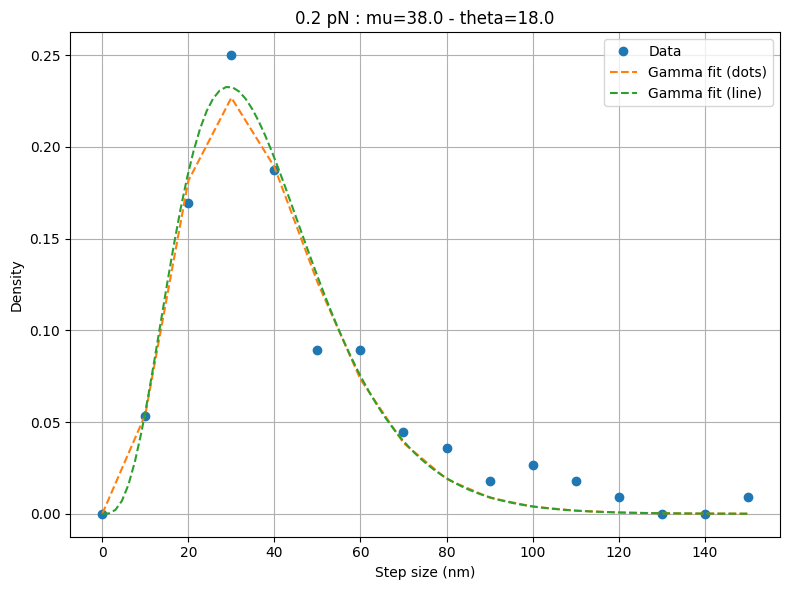

In [2]:
# ─────────────────────────────────────────────
# 2.1 : Ryu Datas
# ─────────────────────────────────────────────

# Datas
data = np.array([1, 0, 0, 1, 2, 3, 2, 4, 5, 10, 10, 21, 28, 19, 6, 0])
y_data = data[::-1] / np.sum(data)
x_data = np.arange(0, 150 + 1, 10).astype(float)
x_safe = x_data.copy()
x_safe[0] = 1e-6

# Filtering
def proba_gamma_fit_counts(x, mu, theta, A):
    y = proba_gamma(mu, theta, x)
    y = np.where(np.isfinite(y), y, 0.0)
    return A * y

# First guesses
A0 = float(y_data.sum())
mu0, theta0 = 30.0, 20.0

# Fitting
popt, pcov = curve_fit(
    proba_gamma_fit_counts,
    x_safe,
    y_data,
    p0=[mu0, theta0, A0],
    bounds=([1e-6, 1e-6, 1e-6], [np.inf, np.inf, np.inf]),
)
print("popt [mu, theta, A]:", popt)

# Fine curve
x_step = 100
x_fine = np.linspace(x_data.min(), x_data.max(), x_step)
y_fine = proba_gamma(popt[0], popt[1], x_fine)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, 'o', label="Data")
plt.plot(x_data, proba_gamma_fit_counts(x_safe, *popt), '--', label="Gamma fit (dots)")
plt.plot(x_fine, y_fine*x_step/len(x_data), '--', label="Gamma fit (line)")
plt.title(f"0.2 pN : mu={np.round(popt[0])} - theta={np.round(popt[1])}")
plt.xlabel("Step size (nm)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 mu_ryu_bp = 182.0 
 theta_ryu_bp = 91.0

 mu_nm = 60 
 theta_nm = 30


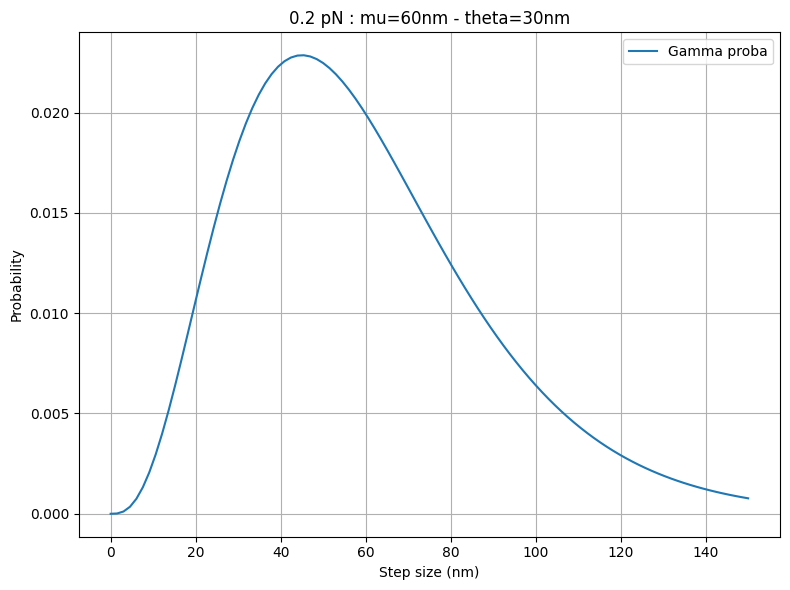

In [3]:
# ─────────────────────────────────────────────
# 2.2 : Conversions
# ─────────────────────────────────────────────

# From nm_in_ryu to bp_in_ryu
mu_ryu_nm = 40     # nm Ryu
theta_ryu_nm = 20  # nm Ryu
ryu_nm_per_bp = 0.220
mu_ryu_bp = mu_ryu_nm / ryu_nm_per_bp
theta_ryu_bp = theta_ryu_nm / ryu_nm_per_bp
print(f"\n mu_ryu_bp = {np.round(mu_ryu_bp)} \n theta_ryu_bp = {np.round(theta_ryu_bp)}")

# From bp_in_ryu to nm
bp_per_nm = 3
mu_nm = int(mu_ryu_bp / bp_per_nm)
theta_nm = int(theta_ryu_bp / bp_per_nm)
print(f"\n mu_nm = {np.round(mu_nm)} \n theta_nm = {np.round(theta_nm)}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_fine, proba_gamma(mu_nm, theta_nm, x_fine), '-', label="Gamma proba")
plt.title(f"0.2 pN : mu={mu_nm}nm - theta={theta_nm}nm")
plt.xlabel("Step size (nm)")
plt.ylabel("Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

l (entier) : [450 332 261 213 178 152 131 115 101  90  81  72  65  59  54  49  44  40
  37  34  31  28  25  23  21  19  17  15  14  12  11   9   8   7   6   5
   4   3   2   1]
d après arrondi l : [0.00206186 0.0027248  0.00337838 0.00403226 0.00469484 0.00534759
 0.0060241  0.00666667 0.00735294 0.008      0.00862069 0.00934579
 0.01       0.0106383  0.01123596 0.01190476 0.01265823 0.01333333
 0.01388889 0.01449275 0.01515152 0.01587302 0.01666667 0.01724138
 0.01785714 0.01851852 0.01923077 0.02       0.02040816 0.0212766
 0.02173913 0.02272727 0.02325581 0.02380952 0.02439024 0.025
 0.02564103 0.02631579 0.02702703 0.02777778]


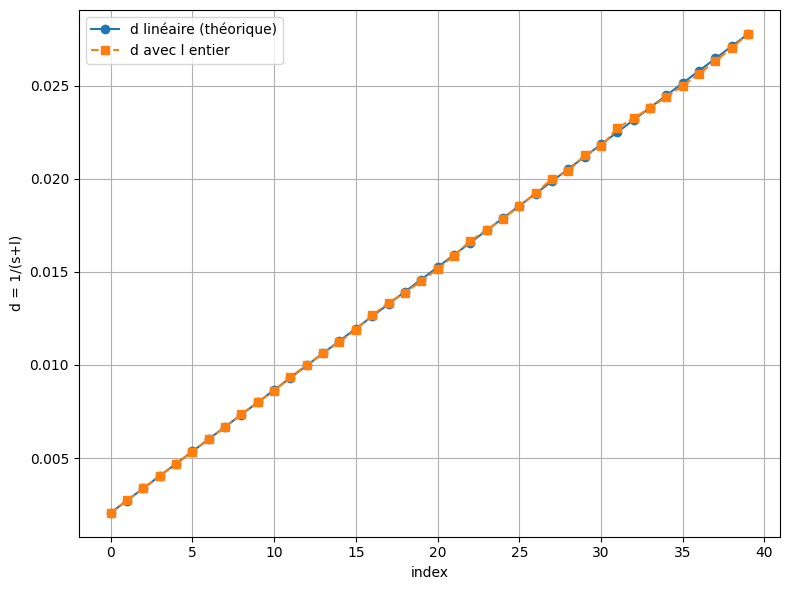

In [4]:
# ─────────────────────────────────────────────
# 2.3 : Linker size Generation 
# ─────────────────────────────────────────────

# Values
s = 35
N = 40
lmin, lmax = 1, 450  # bornes souhaitées pour l (entières)
d = np.linspace(1/(s+lmax), 1/(s+lmin), N)
l = 1/d - s
l_int = np.rint(l).astype(int)  # arrondi au plus proche
d_int = 1/(s + l_int)           # d correspondant après arrondi

# Prints
# print("d linéaire :", d)
# print("l (float)  :", l)
print("l (entier) :", l_int)
print("d après arrondi l :", d_int)

# Plot
plt.figure(figsize=(8,6))
plt.plot(d, 'o-', label="d linéaire (théorique)")
plt.plot(d_int, 's--', label="d avec l entier")
plt.xlabel("index")
plt.ylabel("d = 1/(s+l)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# ─────────────────────────────────────────────
# 3.1 : Reading File - RANDOM
# ─────────────────────────────────────────────

# DataFrame
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-04__PC/nucleo__access_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_merged = pl.scan_parquet(paths).collect()
df_sorted = df_merged.sort(by=["landscape", "bpmin", "l"], descending=[False, False, False])
df_sorted = df_sorted.filter(pl.col("landscape") == "random")

In [ ]:
# ─────────────────────────────────────────────
# 3.2 : Datas
# ─────────────────────────────────────────────

# Getting Values : Inputs
landscape       = df_sorted["landscape"].to_list()[0]
mu              = df_sorted["mu"].to_numpy()[0]
th              = df_sorted["theta"].to_numpy()[0]
s               = df_sorted["s"].to_numpy()[0]
l               = df_sorted["l"].to_numpy()
l_values        = np.unique(l)
bpmin           = df_sorted["bpmin"].to_numpy()
bpmin_values    = np.unique(bpmin)
Lmin            = df_sorted["Lmin"].to_numpy()[0]
Lmax            = df_sorted["Lmax"].to_numpy()[0]
bps             = df_sorted["bps"].to_numpy()[0]
tmax            = df_sorted["tmax"].to_numpy()[0]
dt              = df_sorted["dt"].to_numpy()[0]

# Getting Values : Inputs
results         = df_sorted["results"].to_numpy()
results_mean    = df_sorted["results_mean"].to_numpy()
v_mean          = df_sorted["v_mean"].to_numpy()
vi_med          = df_sorted["vi_med"].to_numpy()
wf              = df_sorted["wf"].to_numpy()


# Calculating Values
d               = 1 / (s + l)
v_th            = mu * d * l
ratio           = v_mean / v_th
c               = (150 + l) / (35 + l)
v_mean_bp       = v_mean * c

# Arrays for plots
chromatin       = np.arange(Lmin, Lmax, bps)
time            = np.arange(0, tmax, dt)


# Print
print(df_sorted)

shape: (225, 64)
┌───────────┬─────┬─────┬───────┬───┬──────────────┬──────────────────────┬───────────┬────────────┐
│ landscape ┆ s   ┆ l   ┆ bpmin ┆ … ┆ xt_over_t    ┆ G                    ┆ bound_low ┆ bound_high │
│ ---       ┆ --- ┆ --- ┆ ---   ┆   ┆ ---          ┆ ---                  ┆ ---       ┆ ---        │
│ str       ┆ i64 ┆ i64 ┆ i64   ┆   ┆ list[f64]    ┆ list[f64]            ┆ i64       ┆ i64        │
╞═══════════╪═════╪═════╪═══════╪═══╪══════════════╪══════════════════════╪═══════════╪════════════╡
│ random    ┆ 35  ┆ 10  ┆ 0     ┆ … ┆ [38.8454,    ┆ [0.989169, 0.995019, ┆ 5         ┆ 80         │
│           ┆     ┆     ┆       ┆   ┆ 38.55485, …  ┆ … 0.97530…           ┆           ┆            │
│           ┆     ┆     ┆       ┆   ┆ 35.75393…    ┆                      ┆           ┆            │
│ random    ┆ 35  ┆ 20  ┆ 0     ┆ … ┆ [66.0155,    ┆ [1.004629, 0.954626, ┆ 5         ┆ 80         │
│           ┆     ┆     ┆       ┆   ┆ 66.22765, …  ┆ … 1.00493…           

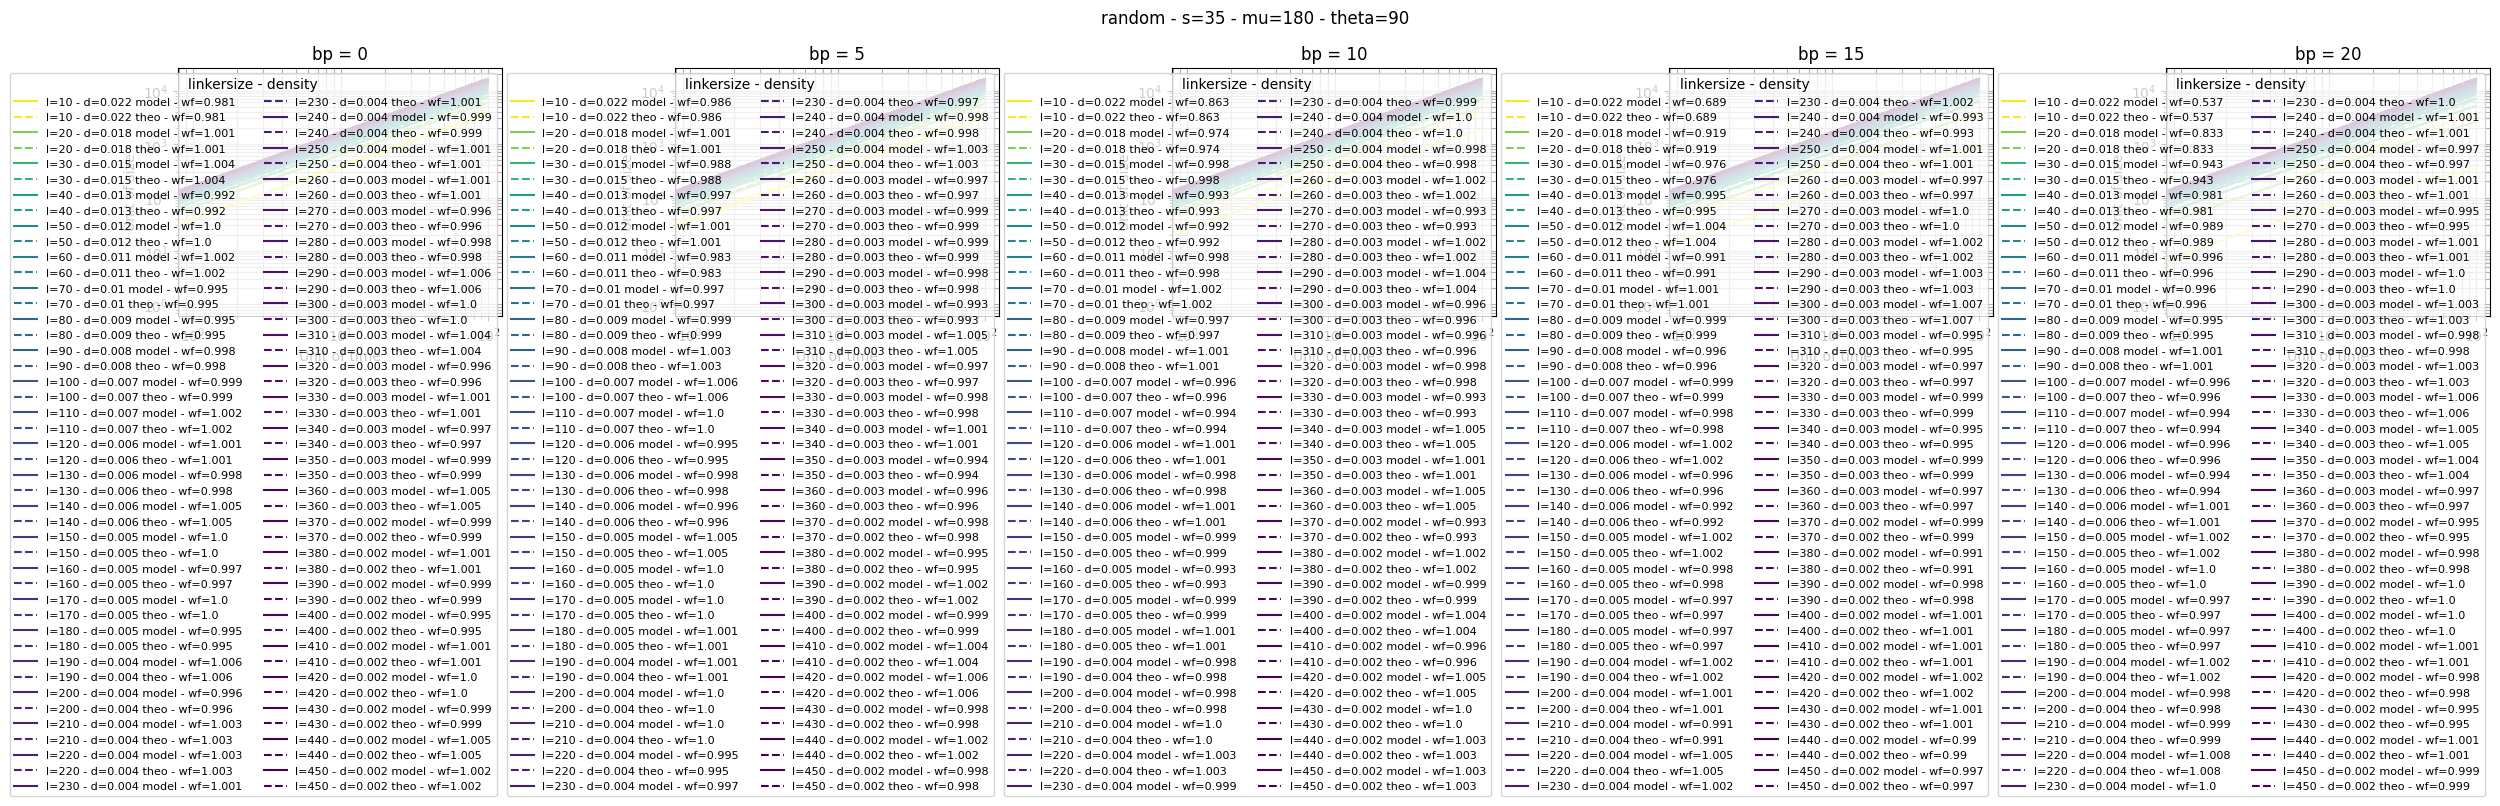

In [9]:
# ─────────────────────────────────────────────
# 3.3 : Plots
# ─────────────────────────────────────────────


# ───────────────────────
# 3.3.1 : Trajectories
# ───────────────────────

nc = len(bpmin_values)
fig, axs = plt.subplots(nrows=1, ncols=nc, figsize=(5*nc,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

if nc == 1:
    axs = [axs]

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(d), vmax=max(d))

for ax, bp in zip(axs, bpmin_values):
    ax.set_title(f"bp = {bp}")
    results_mean_bp = df_sorted.filter(pl.col("bpmin") == bp)["results_mean"].to_numpy()
    wf_bp = df_sorted.filter(pl.col("bpmin") == bp)["wf"].to_numpy()

    for results, l_val, d_val, v_th_val, wf_val in zip(results_mean_bp, l, d, v_th, wf_bp):
        color = cmap(norm(d_val))
        ax.plot(time, results, label=f"l={l_val} - d={np.round(d_val, 3)} model - wf={wf_val}", ls="-", color=color)
        ax.plot(time, time * v_th_val, label=f"l={l_val} - d={np.round(d_val, 3)} theo - wf={wf_val}", ls="--", color=color)
    ax.set_xlabel("Unit of time")
    ax.set_ylabel("Unit of size")
    # ax.set_ylim([-1_000, 17_500])
    ax.grid(True, which="both")
    ax.loglog(True)
    ax.legend(title="linkersize - density", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()

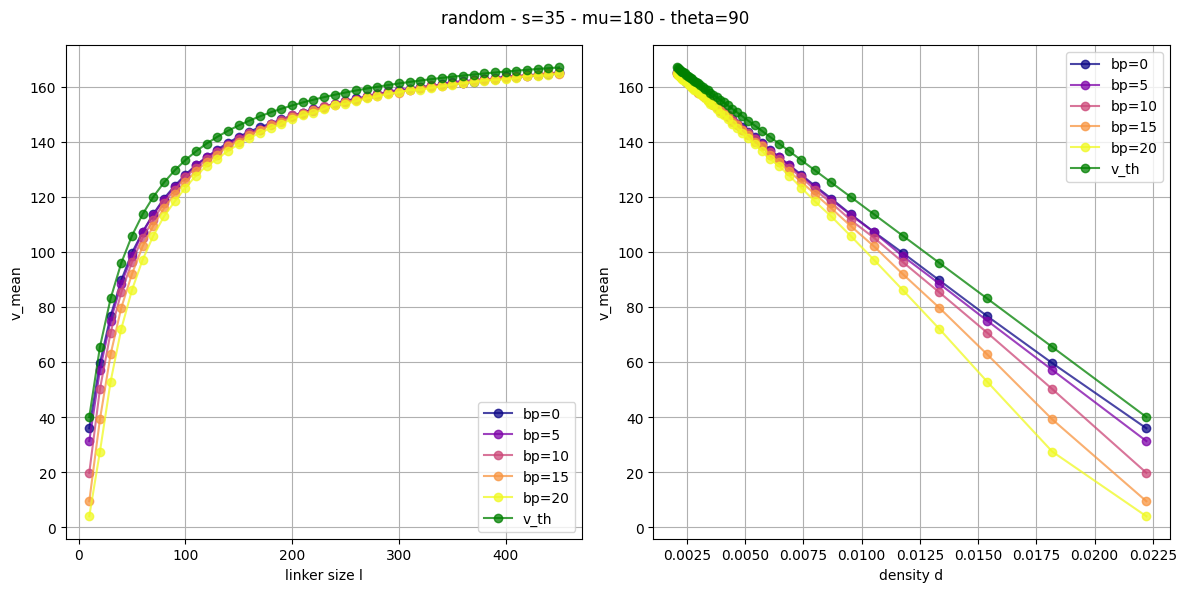

In [10]:
# ───────────────────────
# 3.3.1 : v_mean and vi_med
# ───────────────────────

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    axs[0].plot(l, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    
axs[0].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("v_mean")
axs[0].grid(True, which="both")
axs[0].legend()
# axs[0].loglog(False)

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean")
axs[1].grid(True, which="both")
axs[1].legend()
# axs[1].loglog(False)

plt.tight_layout()
plt.show()

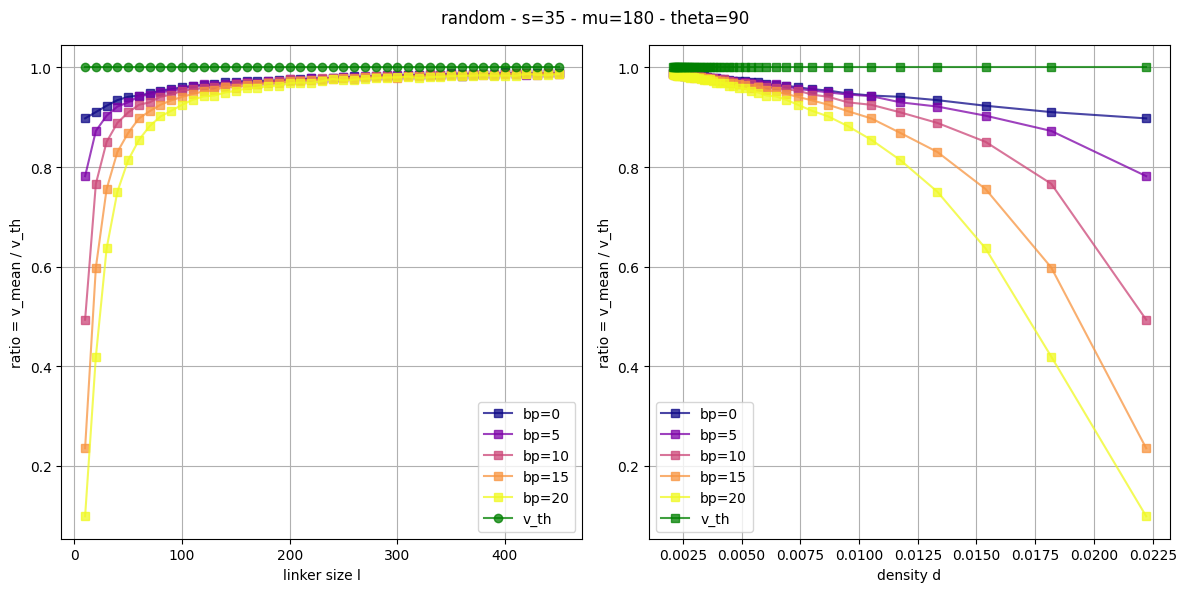

In [11]:
# ───────────────────────
# 3.3.2 : ratio of v_th and v_model
# ───────────────────────

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th

    axs[0].plot(l, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    axs[1].plot(d, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    
axs[0].plot(l, v_th / v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th / v_th, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("ratio = v_mean / v_th")
axs[0].grid(True, which="both")
axs[0].legend()

axs[1].set_xlabel("density d")
axs[1].set_ylabel("ratio = v_mean / v_th")
axs[1].grid(True, which="both")
axs[1].legend()

plt.tight_layout()
plt.show()

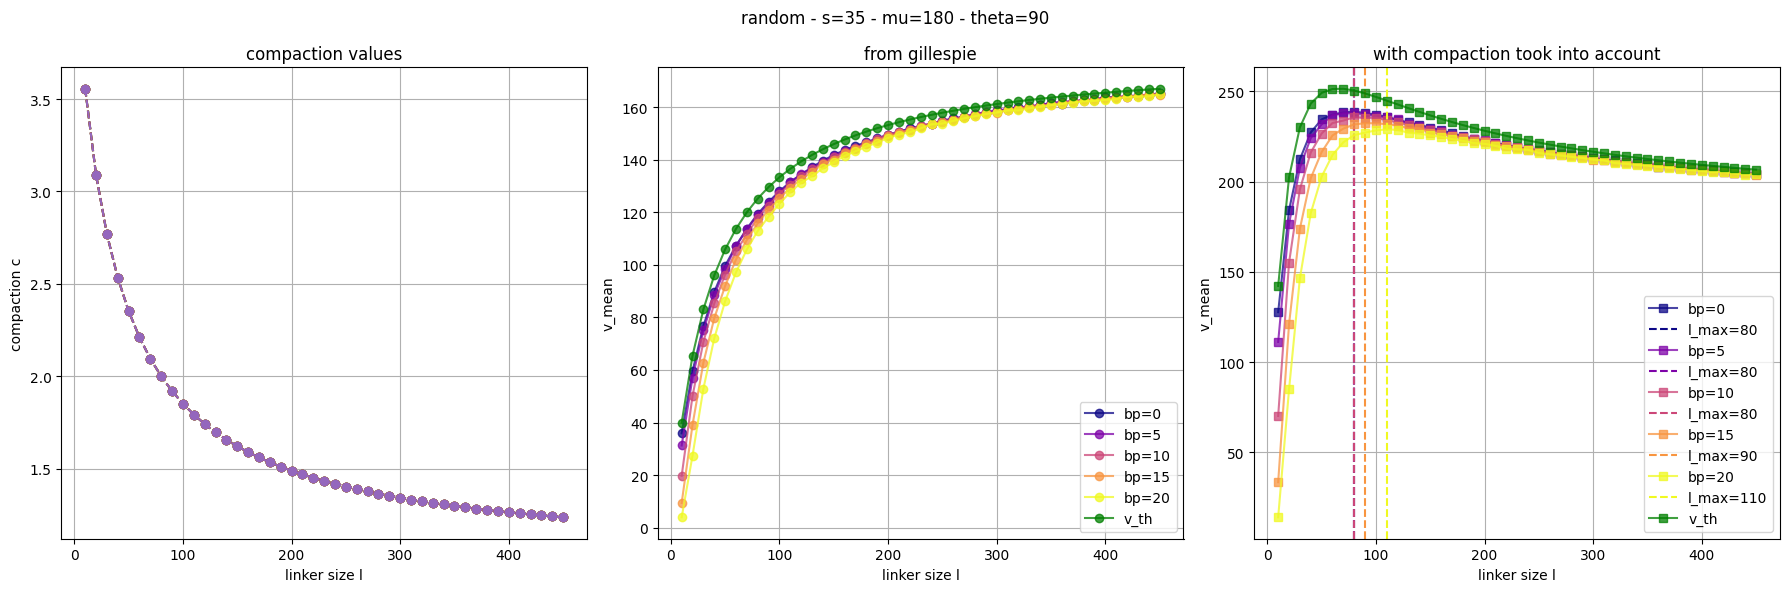

In [ ]:
# ───────────────────────
# 3.3.3 : c - v_mean - v_mean_bp - via l
# ───────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(l, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(l, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(l, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(l[np.argmax(v_mean_bp)], color=color, ls="--", label=f"l_max={l[np.argmax(v_mean_bp)]}")
    
axs[1].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(l, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("linker size l")
axs[1].set_ylabel("v_mean")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("linker size l")
axs[2].set_ylabel("v_mean")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()

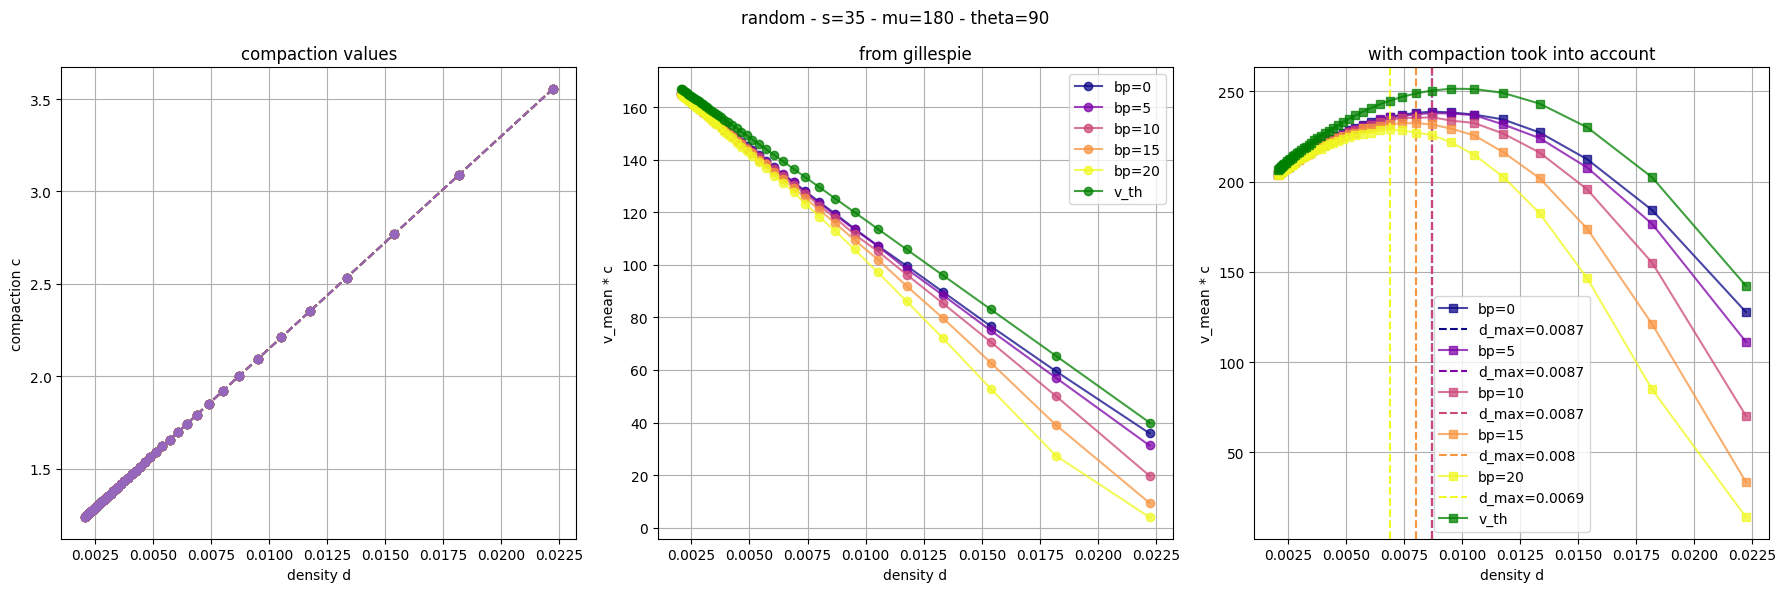

In [ ]:
# ───────────────────────
# 3.3.4 : c - v_mean - v_mean_bp - via d
# ───────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(d, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(d, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(d[np.argmax(v_mean_bp)], color=color, ls="--", label=f"d_max={np.round(d[np.argmax(v_mean_bp)],4)}")

axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(d, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("density d")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean * c")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("density d")
axs[2].set_ylabel("v_mean * c")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [5]:
# ─────────────────────────────────────────────
# 4.1 : Reading File - PERIODIC
# ─────────────────────────────────────────────

# DataFrame
root = Path("/home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-11-06__PC/nucleo__accessperiodic_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]
df_merged = pl.scan_parquet(paths).collect()
df_sorted = df_merged.sort(by=["landscape", "l", "ratio"], descending=[False, False, False])
df_sorted = df_sorted.filter(pl.col("landscape") == "periodic")
print(df_sorted)

shape: (450, 65)
┌───────────┬─────┬─────┬───────┬───┬─────────────┬───────────────────────┬───────────┬────────────┐
│ landscape ┆ s   ┆ l   ┆ bpmin ┆ … ┆ xt_over_t   ┆ G                     ┆ bound_low ┆ bound_high │
│ ---       ┆ --- ┆ --- ┆ ---   ┆   ┆ ---         ┆ ---                   ┆ ---       ┆ ---        │
│ str       ┆ i64 ┆ i64 ┆ i64   ┆   ┆ list[f64]   ┆ list[f64]             ┆ i64       ┆ i64        │
╞═══════════╪═════╪═════╪═══════╪═══╪═════════════╪═══════════════════════╪═══════════╪════════════╡
│ periodic  ┆ 35  ┆ 10  ┆ 0     ┆ … ┆ [41.5842,   ┆ [0.981617, 0.970594,  ┆ 5         ┆ 80         │
│           ┆     ┆     ┆       ┆   ┆ 41.0577, …  ┆ … 0.95045…            ┆           ┆            │
│           ┆     ┆     ┆       ┆   ┆ 40.14309]   ┆                       ┆           ┆            │
│ periodic  ┆ 35  ┆ 10  ┆ 0     ┆ … ┆ [34.094,    ┆ [1.024692, 1.079149,  ┆ 5         ┆ 80         │
│           ┆     ┆     ┆       ┆   ┆ 34.68255, … ┆ … 1.02925…            

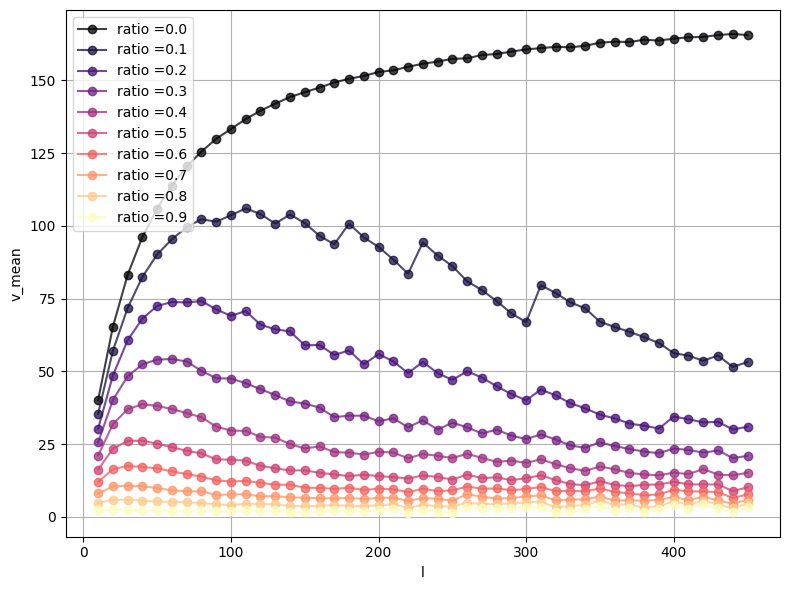

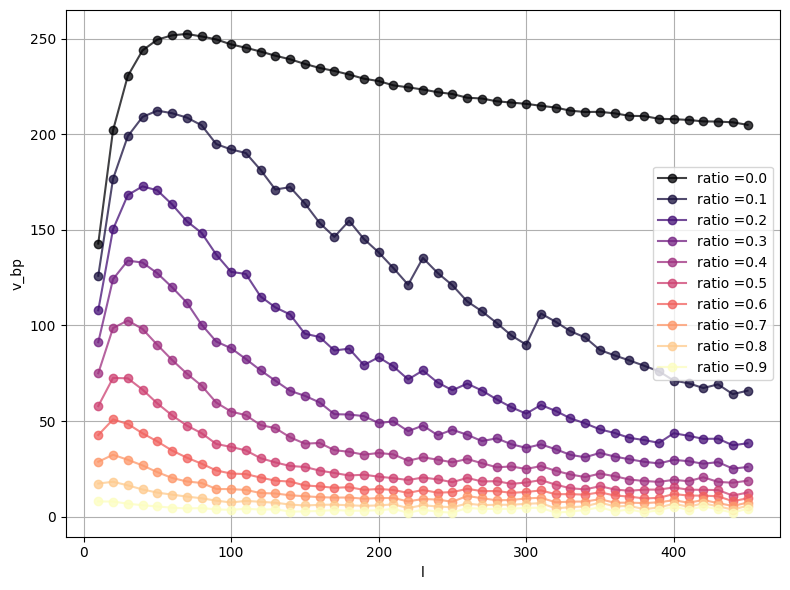

In [25]:
# ─────────────────────────────────────────────
# 4.2.1 : Speed in function of linkers
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.magma
ratios = sorted(df_sorted["ratio"].unique().to_numpy())
norm = plt.Normalize(min(ratios), max(ratios))


# Sites

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("ratio", as_dict=False):
    ratio   = group["ratio"][0]
    l       = group["l"].to_numpy()
    v_mean  = group["v_mean"].to_numpy()
    
    color = cmap(norm(ratio))
    plt.plot(l, v_mean, c=color, marker="o", label=f"ratio ={np.round(ratio, 3)}", alpha=0.75)

plt.xlabel("l")
plt.ylabel("v_mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs

plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("ratio", as_dict=False):
    ratio   = group["ratio"][0]
    s       = group["s"].to_numpy()
    l       = group["l"].to_numpy()
    v_mean  = group["v_mean"].to_numpy()
    c       = (150 + l) / (35 + l)
    vm_bp   = v_mean * c  

    color = cmap(norm(ratio))
    plt.plot(l, vm_bp, c=color, marker="o", label=f"ratio ={np.round(ratio, 3)}", alpha=0.75)

plt.xlabel("l")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

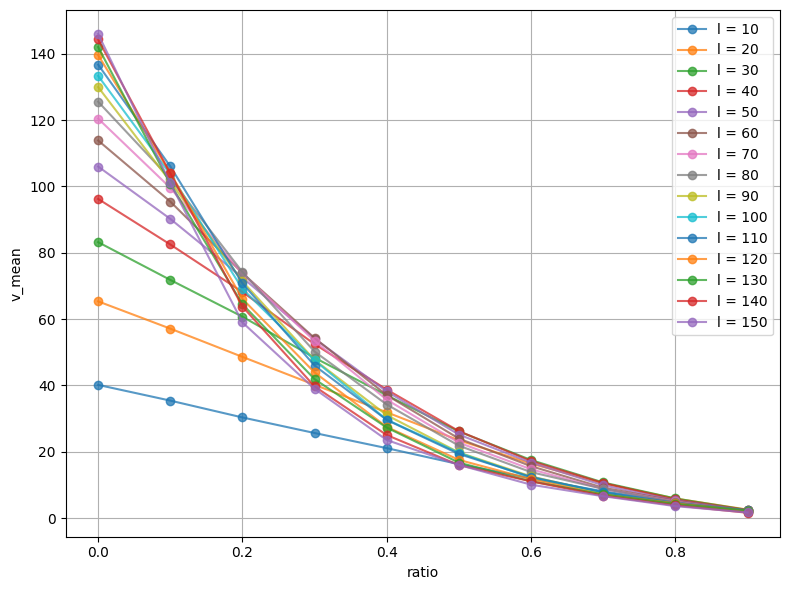

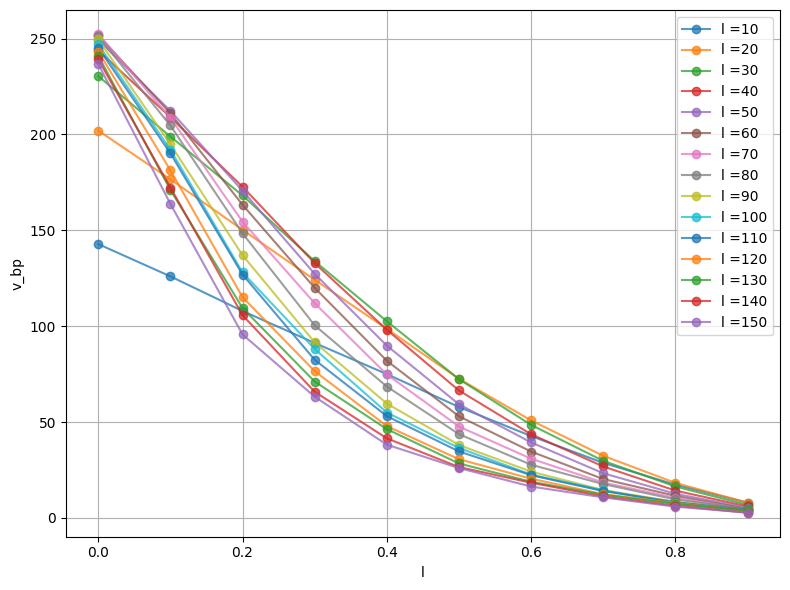

In [ ]:
# ─────────────────────────────────────────────
# 4.2.2 : Speed in function of ratios
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.magma
ratios = sorted(df_sorted["ratio"].unique().to_numpy())
norm = plt.Normalize(min(ratios), max(ratios))


# Sites

df_subset = df_sorted.filter((pl.col("l") >= 5) & (pl.col("l") <= 150))
plt.figure(figsize=(8, 6))

for group in df_subset.partition_by("l", as_dict=False):
    l       = group["l"][0]
    ratio   = group["ratio"].to_numpy()
    v_mean  = group["v_mean"].to_numpy()
    plt.plot(ratio, v_mean, marker="o", label=f"l = {np.round(l, 3)}", alpha=0.75)

plt.xlabel("ratio")
plt.ylabel("v_mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs

plt.figure(figsize=(8,6))

for group in df_subset.partition_by("l", as_dict=False):
    l       = group["l"][0]
    ratio   = group["ratio"].to_numpy()
    s       = group["s"].to_numpy()
    v_mean  = group["v_mean"].to_numpy()
    c       = (150 + l) / (35 + l)
    vm_bp   = v_mean * c  
    # d       = 1 / (s + l)
    # v_th            = mu * d * l
    # ratio           = v_mean / v_th

    plt.plot(ratio, vm_bp, marker="o", label=f"l ={np.round(l, 3)}", alpha=0.75)

plt.xlabel("l")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from ncl.landscape import alpha_periodic
from ncl.metrics import find_blocks

# Generating our obstacle
s = 35
l = 10
obstacle = alpha_periodic(s=s, l=l, alphao=0, alphaf=1, Lmin=0, Lmax=100, bps=1)
print(obstacle)

# Looking for obstacles
alpha_value = 0
couples = find_blocks(obstacle, alpha_value)
print(couples)

# Destroying one determined obstacle
place = np.random.randint(0, len(couples))
# print(couples[place])
obstacle_new = np.copy(obstacle)
print(couples[place][0])
print(couples[place][1])
obstacle_new[couples[place][0] : couples[place][1]] = 1
print(obstacle_new)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[(np.int64(10), np.int64(45)), (np.int64(55), np.int64(90))]
55
90
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from ncl.landscape import alpha_periodic
from ncl.metrics import find_blocks

# Generating our obstacle
s = 35
l = 10
alphaf = 1
alphao = 0
ratio = 0.20
landscape = alpha_periodic(s=s, l=l, alphao=alphao, alphaf=alphaf, Lmin=0, Lmax=1000, bps=1)
# count_1 = np.count_nonzero(obstacle == alphao)
# print(count_1)


def destroy_obstacles(array: np.ndarray, ratio: float, alphao: float, alphaf: float) -> np.ndarray:
    """
    Randomly destroys a fraction of obstacles in a given 1D landscape array.

    Args:
        array (np.ndarray): 1D array representing landscape.
        ratio (float): 
        alphao (float): Value representing the obstacles.
        alphaf (float): Value representing the linkers.

    Returns:
        array_new (np.ndarray): 1D array representing landscape with destroyed obstacles.
    """

    if ratio > 1:
        raise ValueError(f"You cannot give a ratio superior to 1 and you gave ratio={ratio}")
    
    # Looking for obstacles
    couples = find_blocks(array, alphao)
    if len(couples) == 0:
        return np.copy(array)  # nothing to destroy
    
    # Number of obstacles to destroy
    n_obs_destroyed = int(np.floor(ratio * len(couples)))

    # Random choice of the obstacles destroyed
    places = np.random.choice(len(couples), size=n_obs_destroyed, replace=False)

    # Copy the original array
    array_new = np.copy(array)
    
    # Destroy the selected obstacles
    for idx in places:
        start, end = couples[idx]
        array_new[start:end] = alphaf

    return array_new
    

for i in range(0,100_000):
    t = destroy_obstacles(landscape, ratio, alphao, alphaf)

630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630
630


# .